# COVID-19 impact in the Colombian labor world: What does the Unemployment Subsidies Data have to say?

## Introduction

**Business Context.** The ability to monitor and control the unemployment subsidies properly has a significant impact on the “Superintendencia del Subsidio Familiar” decisions and the “Fondo de Solidaridad y Fomento al Empleo y Protección al Cesante” (FOSFEC) financial statements. We are aiming to assess the characteristics of the population of beneficiaries of the "Cajas de compensacion", and the current state of the subsidies and the population of beneficiaries receiving it. To control the fund's management the "Cajas de Compensación" report the unemployment subsidy status using the file "5-312 INFORMACION MICRODATO BENEFICIARIOS TRANSFERENCIA ECONÓMICA EMERGENCIA ECONÓMICA SOCIAL Y ECOLÓGICA". Our findings will be used as the basis of furder controlling and ensuring that the subsidies reach the most vulnerable population.

**Business Problem.** Your task is to build a **minimal** model to predict the cost of insurance from the data set using various characteristics of a policyholder.

**Analytical Context.** The data resides in a Postgres database which has been pre-cleaned. We will be using the Python `pandas_profiling` package to  analyze this data.

In [1]:
import pandas                  as pd
import re
import io
from unicodedata           import normalize
from sqlalchemy            import create_engine
import numpy                   as np
import numpy.random            as nr
from numpy.linalg          import norm
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import requests
import json
from pandas.io.json        import json_normalize
from requests.auth         import HTTPBasicAuth 
from tqdm.auto             import tqdm, trange


# Visualisation
import pandas_profiling
from pandas_profiling      import ProfileReport
import matplotlib.pyplot       as plt
import seaborn                 as sns

# Read in relevant libraries and packages from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Database connection

In [2]:
host = 'ssf.csqdzeslttvs.us-east-1.rds.amazonaws.com'
port = 5432
user = 'postgres'
password = 'BRfM)p4JT?JecpZz'
database = 'postgres'

In [3]:
#connection to DB Postgres FOSFEC
connDB = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}', encoding = 'utf-8')
conn = connDB.raw_connection()
cur = conn.cursor()

## Reading table from database with pandas

Using the SQL query described below, a "Golden Record" was created to get the data from the Postgres DataBase:


**Columns from the d_beneficiario table:**
> SELECT


>b.id, b.genero , 
b.edad, b.rangoedad ,  
b.categoria_afiliado , 
b.ubicacion_residencia ,
b.grupo_etnico , 
b.caracteristica_poblacion , 
b.fctor_vulnerabilidad , 
b.conflicto, b.desplazamiento, 
b.discapacidad, 



**Columns from the d_caja_compensacion table:**

>cj.caja_name , 

**Columns from the d_municipio table:**

>mn.municipio , 
mn.departamento , 
mn.region

**Columns from the 5-312A_CIRCULAR_COVID table:**

>a.fecha_reporte , 
a.fecha_perdida_empleo , 
a.fecha_radicacion , 
a.fecha_aprobacion, 
a.numero_dias_aprobacion ,   
a.fecha_liquidacion_beneficio , 
a.fecha_liquidacion_beneficio , 
a.fecha_suspension_beneficio , 
a.fecha_reactivacion_beneficio, 
a.numero_beneficios_liquidados, 
a.beneficio_aprobado  


**5-312A_CIRCULAR_COVID table joined with d_beneficiario:**
>FROM 
dwh."5-312A_CIRCULAR_COVID" as a 
LEFT outer JOIN 
>dwh.d_beneficiario as b 
on a.beneficiarioid = b.beneficiarioid

**JOINED with d_caja_compensacion:**
>LEFT outer JOIN dwh.d_caja_compensacion cj 
on cj.cajaid  = a.cajaid 

**JOINED with d_municipio:**
>LEFT outer JOIN 
dwh.d_municipio mn 
on mn.municipioid = a.municipioid

**Applied filters**

***Registries after the subsidy creation***

***Registries for people over 14 and under 71***

>WHERE
a.fecha_radicacion>20200327




In [4]:
# Reading table from database with pandas
dfgoldenrecord = pd.read_sql('select b.id, b.genero , b.edad, b.rangoedad ,  b.categoria_afiliado , b.ubicacion_residencia ,b.grupo_etnico , b.caracteristica_poblacion , b.fctor_vulnerabilidad , b.conflicto, b.desplazamiento, b.discapacidad, a.fecha_reporte , a.fecha_perdida_empleo , cj.caja_name , mn.municipio , mn.departamento , mn.region , a.fecha_radicacion , a.fecha_aprobacion, a.numero_dias_aprobacion ,   a.fecha_liquidacion_beneficio , a.fecha_liquidacion_beneficio , a.fecha_suspension_beneficio , a.fecha_reactivacion_beneficio, a.numero_beneficios_liquidados, a.beneficio_aprobado  FROM dwh."5-312A_CIRCULAR_COVID" as a left outer join dwh.d_beneficiario as b on a.beneficiarioid = b.beneficiarioid left outer join dwh.d_caja_compensacion cj on cj.cajaid  = a.cajaid left outer join dwh.d_municipio mn on mn.municipioid = a.municipioid where a.fecha_radicacion > 20200327', connDB )

In [5]:
#size of DF
dfgoldenrecord.shape

(460377, 27)

In [6]:
#convert boolean to int
dfgoldenrecord["beneficio_aprobado"] = dfgoldenrecord["beneficio_aprobado"].astype(int)

In [7]:
dfgoldenrecord["beneficio_aprobado"].describe()

count    460377.000000
mean          0.540049
std           0.498394
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: beneficio_aprobado, dtype: float64

## Beneficiary data ##

In [8]:
df_beneficiario = pd.read_sql('select b.id, b.genero , b.edad, b.rangoedad ,  b.categoria_afiliado , b.ubicacion_residencia ,b.grupo_etnico , b.caracteristica_poblacion , b.fctor_vulnerabilidad , b.conflicto, b.desplazamiento, b.discapacidad, a.fecha_reporte , a.fecha_perdida_empleo , cj.caja_name , mn.municipio , mn.departamento , mn.region , a.fecha_radicacion , a.fecha_aprobacion, a.numero_dias_aprobacion ,   a.fecha_liquidacion_beneficio , a.fecha_liquidacion_beneficio , a.fecha_suspension_beneficio , a.fecha_reactivacion_beneficio, a.numero_beneficios_liquidados, a.beneficio_aprobado  FROM dwh."5-312A_CIRCULAR_COVID" as a left outer join dwh.d_beneficiario as b on a.beneficiarioid = b.beneficiarioid left outer join dwh.d_caja_compensacion cj on cj.cajaid  = a.cajaid left outer join dwh.d_municipio mn on mn.municipioid = a.municipioid where a.fecha_radicacion > 20200327', connDB )

The following are the columns in the df_beneficiario dataset:

      
---  ------                    --------------   -----         
 0.   **beneficiarioid**: Unique registry index       
 1.   **genero**: Beneficiary's sex (Hombre, Mujer, No aplica, Indeterminado)       
 2.   **fecha_nacimiento**:Beneficiary's birth date, in the format: YYYYMMDD (YYYY: Year, MM:Month, DD: Day) 
 3.   **id**: Beneficiary's Identification Number, should be reported without periods or commas.  
 4.   **categoria_afiliado** Code of the category assigned to the member of the "Family Compensation Fund" according to the salary range he had  when he was affiliated. (A, B, C, D, Empresas Fondos de Ley (Solo aplica para el reporte de cobertura en Servicios Sociales), Alianza Categoría A (Esta categoría se utiliza para las alianzas entre Cajas de Compensación), Alianza Categoría B (Esta categoría se utiliza para las alianzas entre Cajas de Compensación), Alianza Categoría C (Esta categoría se utiliza para las alianzas entre Cajas de Compensación), Convenios y Facultativos, Abierto al Público, Empresa no afiliada (aplica solo para reporte de tarifas e ingreso por tarifas)
 5.   **ubicacion_residencia** Code of the location area where the beneficiary resides, taking into account Circular 032 of 2016 of the Ministry of Labor (Urbana, Rural)     
 6.   **direccion_residencia**      Correspondence address of the beneficiary reported to the "caja de compensacion"    
 7.   **grupo_etnico** Indicate the code of the ethnic group to which the beneficiary of the subsidy belongs (Afrocolombiano, Comunidad negra, Indígena, Palanquero, Raizal del archipiélago de San Andrés, Providencia y Santa Catalina, Room/gitano, No se auto reconoce en ninguno de los anteriores) 
 8.   **caracteristica_poblacion** Indicate the code of the population group to which the beneficiary of the subsidy belongs (Víctimas del conflicto armado, En condición de desplazamiento, En condición de discapacidad física, Víctimas del conflicto armado y en condición de desplazamiento, Víctimas del conflicto armado y en condición de discapacidad física, Víctimas del conflicto armado en condición de desplazamiento y en condición de discapacidad física, En condición de desplazamiento y en condición de discapacidad física, No aplica)      
 9.   **fctor_vulnerabilidad** Indicate the code of the disability condition presented by the beneficiary of the subsidy. (Desplazado, Víctima del conflicto armado (No desplazado), Desmovilizado o reinsertado, Hijo (as) de desmovilizados o reisertados, Damnificado desastre natural, Cabeza de familia, Hijo (as) de madres cabeza de familia, En condición de discapacidad, Población migrante, Población zonas frontera (Nacionales), Ejercicio del trabajo sexual, No aplica)
 10.  **validfrom**
 11.  **validto**
 12.  **isvalid**
 13.  **edad** Using the information from the'fecha_nacimiento' the age of the beneficiary was calculated. 
 14.  **conflicto** Using the field "caracteristica_poblacion" this field was created to identify the popupation that has been affected by armed conflict.   
 15.  **desplazamiento** Using the field "caracteristica_poblacion" this field was created to identify the popupation that has been displaced..     
 16.  **discapacidad** Using the field "caracteristica_poblacion" this field was created to identify the disabled  popupation.     
 17.  **noaplica** Using the field "caracteristica_poblacion" this field was created to identify the popupation without "conflicto", "desplazamiento" or "discapacidad".     
 18.  **municipioid** Municio where the beneficiary lives. 
 19.  **rangoedad** Using the information from the "edad" (age) field the beneficiaries were classiffied by generations using their age range.
- 1: < 16
- 2: 15 - 17 
- 3: 18 - 27
- 4: 28 - 37
- 5: 38 - 47
- 6: 48 - 57
- 7: 58 - 67
- 8: 68 - 77
- 9: > 77

## Data Cleaning

As part of our data cleaning process we replaced the age rank 'rangoedad' a more descriptive name by rank:

In [9]:
df_beneficiario.loc[df_beneficiario['rangoedad'] == 1, ['rangoedad']] = '1.   <16'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 2, ['rangoedad']] = '2.   15 - 17'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 3, ['rangoedad']] = '3.   18 - 27'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 4, ['rangoedad']] = '4.   28 - 37'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 5, ['rangoedad']] = '5.   38 - 47'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 6, ['rangoedad']] ='6.   48 - 57'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 7, ['rangoedad']] = '7.   58 - 67'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 8, ['rangoedad']] ='8.   68 - 77'
df_beneficiario.loc[df_beneficiario['rangoedad'] == 9, ['rangoedad']] ='9.   > 77'

We also replaced the values with special characters in some of the values of the dataset: 

In [10]:
df_beneficiario.loc[df_beneficiario['grupo_etnico'] == 'INDÃ�GENA', ['grupo_etnico']] = 'INDIGENA'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'EN CONDICIÃ“N DE DESPLAZAMIENTO Y EN CONDICIÃ“N DE DISCAPACIDAD FÃ�SICA', ['caracteristica_poblacion']] = 'EN CONDICION DE DESPLAZAMIENTO Y EN CONDICION DE DISCAPACIDAD FISICA'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'VÃ�CTIMAS DEL CONFLICTO ARMADO', ['caracteristica_poblacion']] = 'VICTIMAS DEL CONFLICTO ARMADO'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'EN CONDICIÃ“N DE DESPLAZAMIENTO', ['caracteristica_poblacion']] = 'EN CONDICION DE DESPLAZAMIENTO'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'VÃ�CTIMAS DEL CONFLICTO ARMADO Y EN CONDICIÃ“N DE DESPLAZAMIENTO', ['caracteristica_poblacion']] = 'VICTIMAS DEL CONFLICTO ARMADO Y EN CONDICION DE DESPLAZAMIENTO'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'EN CONDICIÃ“N DE DISCAPACIDAD FÃ�SICA', ['caracteristica_poblacion']] = 'EN CONDICION DE DISCAPACIDAD FISICA'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'VÃ�CTIMAS DEL CONFLICTO ARMADO Y EN CONDICIÃ“N DE DISCAPACIDAD FÃ�SICA', ['caracteristica_poblacion']] = 'VICTIMAS DEL CONFLICTO ARMADO Y EN CONDICION DE DISCAPACIDAD FISICA'
df_beneficiario.loc[df_beneficiario['caracteristica_poblacion'] == 'VÃ�CTIMAS DEL CONFLICTO ARMADO EN CONDICIÃ“N DE DESPLAZAMIENTO Y EN CONDICIÃ“N DE DISCAPACIDAD FÃ�SICA', ['caracteristica_poblacion']] = 'VICTIMAS DEL CONFLICTO ARMADO EN CONDICION DE DESPLAZAMIENTO Y EN CONDICION DE DISCAPACIDAD FISICA'

### Edad

In [11]:
df_beneficiario['edad'].describe()

count    460377.000000
mean         36.885307
std          10.253818
min         -10.000000
25%          29.000000
50%          35.000000
75%          43.000000
max         120.000000
Name: edad, dtype: float64

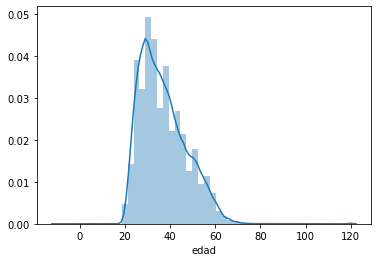

In [12]:
ax = sns.distplot(a=df_beneficiario['edad'])
plt.show()

After an initial inspection of the 'edad' column, we observe that there are registries with negative ages and ages up to 120 years.

##### Beneficiaries under 15

In Colombia the legal age to start working is 15th, so there must be a mistake on the benefieciaries that have age registries under 15, lets explore this data:

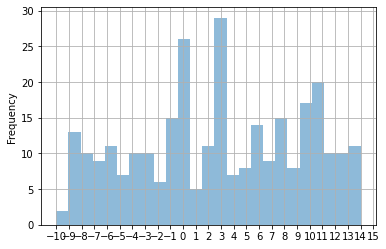

In [13]:
df_beneficiario[df_beneficiario['edad']<15]['edad'].plot.hist(by='edad', bins=25, alpha=0.5, 
                                                              xticks=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                                                             grid=True)

In [14]:
df_beneficiario[df_beneficiario['edad']<15]['edad'].describe()

count    293.000000
mean       2.856655
std        6.770195
min      -10.000000
25%       -2.000000
50%        3.000000
75%        9.000000
max       14.000000
Name: edad, dtype: float64

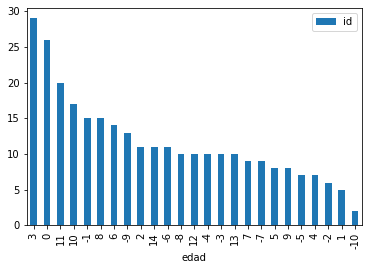

In [15]:
df_beneficiario[df_beneficiario['edad']<15][['edad','id']].groupby(pd.Grouper(key="edad")).count().sort_values(by='id',ascending=False).plot(kind='bar')



In [16]:
df_beneficiario[df_beneficiario['edad']<15][['edad','id']].groupby(pd.Grouper(key="edad")).count().sort_values(by='id',ascending=False).head(3)

id
edad    
3     29
0     26
11    20

##### Beneficiaries over 77

In Colombia the retirement age is 62 years, and in theory people over 77 years shouldn't be working and therefore shouldn't be applying the the unemployment subsidie, lets explore the data:

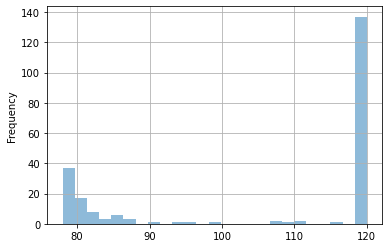

In [17]:
df_beneficiario[df_beneficiario['edad']>77]['edad'].plot.hist(by='edad', bins=25, alpha=0.5, grid=True)

In [18]:
df_beneficiario[df_beneficiario['edad']>77]['edad'].describe()

count    221.000000
mean     106.036199
std       18.588573
min       78.000000
25%       82.000000
50%      120.000000
75%      120.000000
max      120.000000
Name: edad, dtype: float64

In [19]:
df_beneficiario[df_beneficiario['edad']>77][['edad','id']].groupby(pd.Grouper(key="edad")).count().sort_values(by='id',ascending=False).head(3)

id
edad     
120   134
79     21
78     16

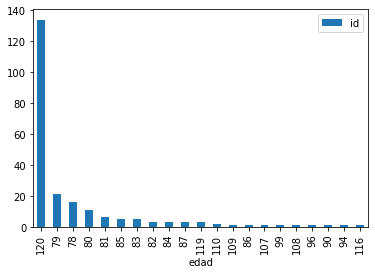

In [20]:
df_beneficiario[df_beneficiario['edad']>77][['edad','id']].groupby(pd.Grouper(key="edad")).count().sort_values(by='id',ascending=False).plot(kind='bar')

We observe the the mode for the ages after 77 is 120 and we also observe a big gap between that age and the next age 79, probably an starndad date is introduced when the birth date is unknown. 

##### "Not Clean Age"

In [21]:
df_beneficiario.loc[(df_beneficiario['edad'] < 15) | (df_beneficiario['edad'] >77),['edad']].describe()

edad
count  514.000000
mean    47.219844
std     52.807572
min    -10.000000
25%      2.000000
50%     11.000000
75%    120.000000
max    120.000000

### Edad data cleaning

In order to clean the "edad" field, we decided to match the beneficiaries with "out of range" ages with beneficiaries that have ages between 15 and 77 based on similarities in measured covariates. 

In addition to the *cleaned - data*, $ (\mathbf{X}_1, \mathbf{Y}_1),\dots,  (\mathbf{X}_n, \mathbf{Y}_n)$ we have data from $m=560$ beneficiaries with registered ages with in the "incorrect rank". Let us denote the characteristics of these *Not Cleaned - data* benefieciaries by $\mathbf{X_1'}, \mathbf{X_2'}, \dots, \mathbf{X_m'}$.

For each *Not cleaned - data* beneficiary $j\in \{1, \dots, m\}$ with characteristics $\mathbf{X}_j'$, our objective is to find a *Clean data* benefieciary $i\in\{1,\dots, n\}$ with characteristics $\mathbf{X}_i$, such that $\mathbf{X}_i$ and $\mathbf{X}_j'$ are as close as possible according to some **measure of distance**. 
    
We will use the **euclidean distance**. 

Recall that given a pair of vectors $X=(x_1,\dots, x_p)$ and $X'=(x_1',\dots, x_p')$, the euclidean distance between $X$ and $X'$ is the value
$$
d(X,X'):=\sqrt{(x_1-x_1')^2+(x_2-x_2')^2+\dots+(x_p-x_p')^2}.
$$
Thus, for each Non clean-data beneficiary $j$, our matching algorithm should find the clean-data beneficiary $i$ with $d(\mathbf{X}_i,\mathbf{X'}_j)$ as small as possible.
    
This form of matching is called **nearest-neighbor-one matching (KNN-1)** and is among the most popular and intuitive variants of matching.

#### Matching Process

To begin our mactching process by getting a subset of the "Golden Record" data set with the covariates we want to avaluate:

In [22]:
df_small=pd.DataFrame(dfgoldenrecord[['id','genero','edad','rangoedad','categoria_afiliado', 'grupo_etnico','ubicacion_residencia','conflicto', 'desplazamiento', 'discapacidad', 'fecha_perdida_empleo','caja_name', 'region','beneficio_aprobado']])

Then, we store the so called "cleaned_age" and "not_cleaned " in two different data frames:

In [23]:
cleaned_age=df_small.loc[(df_small['edad'] > 14) & (df_small['edad'] <78),['id','genero', 'edad','rangoedad', 'categoria_afiliado', 'grupo_etnico',
       'ubicacion_residencia', 'conflicto', 'desplazamiento', 'discapacidad',
       'fecha_perdida_empleo', 'caja_name', 'region', 'beneficio_aprobado']].copy()
not_cleaned_age=df_small.loc[(df_small['edad'] < 15) | (df_small['edad'] >77),['id','genero','categoria_afiliado', 'grupo_etnico',
       'ubicacion_residencia', 'conflicto', 'desplazamiento', 'discapacidad',
       'fecha_perdida_empleo', 'caja_name', 'region', 'beneficio_aprobado']].copy()

newage = cleaned_age['edad'].tolist()
newrango = cleaned_age['rangoedad'].tolist()

To make all variables numeric we "hot encoded" the categorical variables using the function ```.get_dummies()```, we also remove from the "cleaned_age" dataframe  the columns not present in the "Not cleaned" dataframe:

In [24]:
#one hot encoding
cleaned_age = pd.DataFrame(pd.get_dummies(cleaned_age,columns=['grupo_etnico','categoria_afiliado','ubicacion_residencia','region','caja_name','genero']))
not_cleaned_age = pd.DataFrame(pd.get_dummies(not_cleaned_age,columns=['grupo_etnico','categoria_afiliado','ubicacion_residencia','region','caja_name','genero']))
cleaned_age.drop(cleaned_age.columns.difference(not_cleaned_age.columns).tolist(),axis=1,inplace=True)
cleaned_age.shape



(459863, 59)

Before proceeding with the matching, it is important that we scale properly the different features of our data. There exist various methods used for *feature scaling*, some popular options are *min-max normalization, standardization* and *scaling to unit length*.

Here will scale each feature so that the columns of our data have unit length using "min-max normalization" y both dataframes:

In [25]:
# We have 2 columns that are not on the same scale as others. Lets normalize them
column_normalize = ['fecha_perdida_empleo']

for col in column_normalize:
    cleaned_age[col] = minmax_scale(cleaned_age[col])

for col in column_normalize:
    not_cleaned_age[col] = minmax_scale(not_cleaned_age[col])

We created the matched data set the normalized "Cleaned_Age" data using the normalized "Not cleaned" data. We used tqdm to track progress. We use the following  to speed up the computation:


If $X$ is an $n\times k$ matrix and $Y$ is an $m\times k$ matrix, the squared euclidean distance between the i-th row of $X$ and the $j$-th row of $Y$ equals the $ij$-entry of the matrix:
$$
M=norm(X)\cdot ones(m)^\top-2X\cdot Y^\top+ones(n)\cdot norm(Y)^\top,
$$
where $norm(X)$ is the vector of **squared** norms of each row of $X$ and $ones(p)$ is an all ones column vector of length $p$.  

In [26]:
n, p = not_cleaned_age.shape
m, q = cleaned_age.shape

X = np.array(not_cleaned_age)
Y = np.array(cleaned_age)
onesn=np.ones((n,1))
onesm=np.ones((m,1))

X = X.astype(np.float)
Y = Y.astype(np.float)

#Remember that we need to square the norm here
normX=norm(X,axis=1).reshape((n,1))**2
normY=norm(Y,axis=1).reshape((m,1))**2

#The formula given for M
M=normX.dot(np.transpose(onesm))-2*X.dot(np.transpose(Y))+onesn.dot(np.transpose(normY))
M.shape

(514, 459863)

After applying the formula we end up with a matrix M with 460377 rows and 514 columns with the two dataframes value distance between them.

Below, using the matrix M we will replace the columns 'edad' and 'rangoedad' with the matched values from the "clean data" dataframe in the "not clean data" dataframe:

In [27]:

matchs=[] #Let us record the matches of each clean beneficiary here.
newages=[]
newranks=[]

#Our goal is to calculate the average age of the "clean data" population that 
# after the matching. This is stored in matched_mean: 
matched_mean=0

#Finally, we look for the minimum value across each column
for i in trange(n, desc="Number records processed"):
    vec=M[i,:]
    j=np.argwhere(vec == np.min(vec))
    index=j[0][0]
    matchs.append(index)
    matched_mean+=newage[index]
    newages.append(newage[index])
    newranks.append(newrango[index])

print('The mean of age after matching is ',matched_mean/n)  

not_cleaned_age['edad']=newages
not_cleaned_age['rangoedad']=newranks


The mean of age after matching is  39.69649805447471


In [28]:
df_small=df_small.merge(not_cleaned_age[['id','edad','rangoedad']],on='id',how='left')

In [29]:
df_small['edad_y'] = df_small['edad_y'].fillna(df_small['edad_x'])
df_small['rangoedad_y'] = df_small['rangoedad_y'].fillna(df_small['rangoedad_x'])
df_small.drop(['edad_x','rangoedad_x'],axis=1,inplace=True)
df_small.rename(columns = {'edad_y':'edad'}, inplace = True) 
df_small.rename(columns = {'rangoedad_y':'rangoedad'}, inplace = True) 

In [30]:
df_small.head(4)

id  genero categoria_afiliado               grupo_etnico  \
0  526723791937696782  HOMBRE                  A  NINGUNO DE LOS ANTERIORES   
1   41519093314428873  HOMBRE                  A  NINGUNO DE LOS ANTERIORES   
2    4494102545661300  HOMBRE                  A  NINGUNO DE LOS ANTERIORES   
3   41565281012797113  HOMBRE                  A  NINGUNO DE LOS ANTERIORES   

  ubicacion_residencia  conflicto  desplazamiento  discapacidad  \
0               URBANA          0               0             0   
1               URBANA          0               0             0   
2               URBANA          0               0             0   
3               URBANA          0               0             0   

   fecha_perdida_empleo    caja_name                 region  \
0              20200115    COMPENSAR  Región Centro Oriente   
1              20190228        CAFAM  Región Centro Oriente   
2              19000101  COLSUBSIDIO  Región Centro Oriente   
3              19000101  COLSUBSIDIO  Región Centro Oriente   

   beneficio_aprobado  edad  rangoedad  
0                   1  33.0        4.0  
1                   1  42.0        5.0  
2                   0  38.0        5.0  
3                   0  42.0        5.0

In [31]:
df_small.describe()

conflicto  desplazamiento   discapacidad  fecha_perdida_empleo  \
count  460377.000000   460377.000000  460377.000000          4.603770e+05   
mean        0.030356        0.021786       0.003449          1.997561e+07   
std         0.171564        0.145986       0.058630          4.622585e+05   
min         0.000000        0.000000       0.000000          1.900010e+07   
25%         0.000000        0.000000       0.000000          2.018073e+07   
50%         0.000000        0.000000       0.000000          2.020011e+07   
75%         0.000000        0.000000       0.000000          2.020032e+07   
max         1.000000        1.000000       1.000000          2.035052e+07   

       beneficio_aprobado           edad      rangoedad  
count       460377.000000  460377.000000  460377.000000  
mean             0.540049      36.876907       4.433039  
std              0.498394      10.105245       1.062781  
min              0.000000      15.000000       2.000000  
25%              0.000000      29.000000       4.000000  
50%              1.000000      35.000000       4.000000  
75%              1.000000      43.000000       5.000000  
max              1.000000      77.000000       8.000000

## Exploration Data Analysis

## Variables histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D501D9E80>,
      dtype=object)

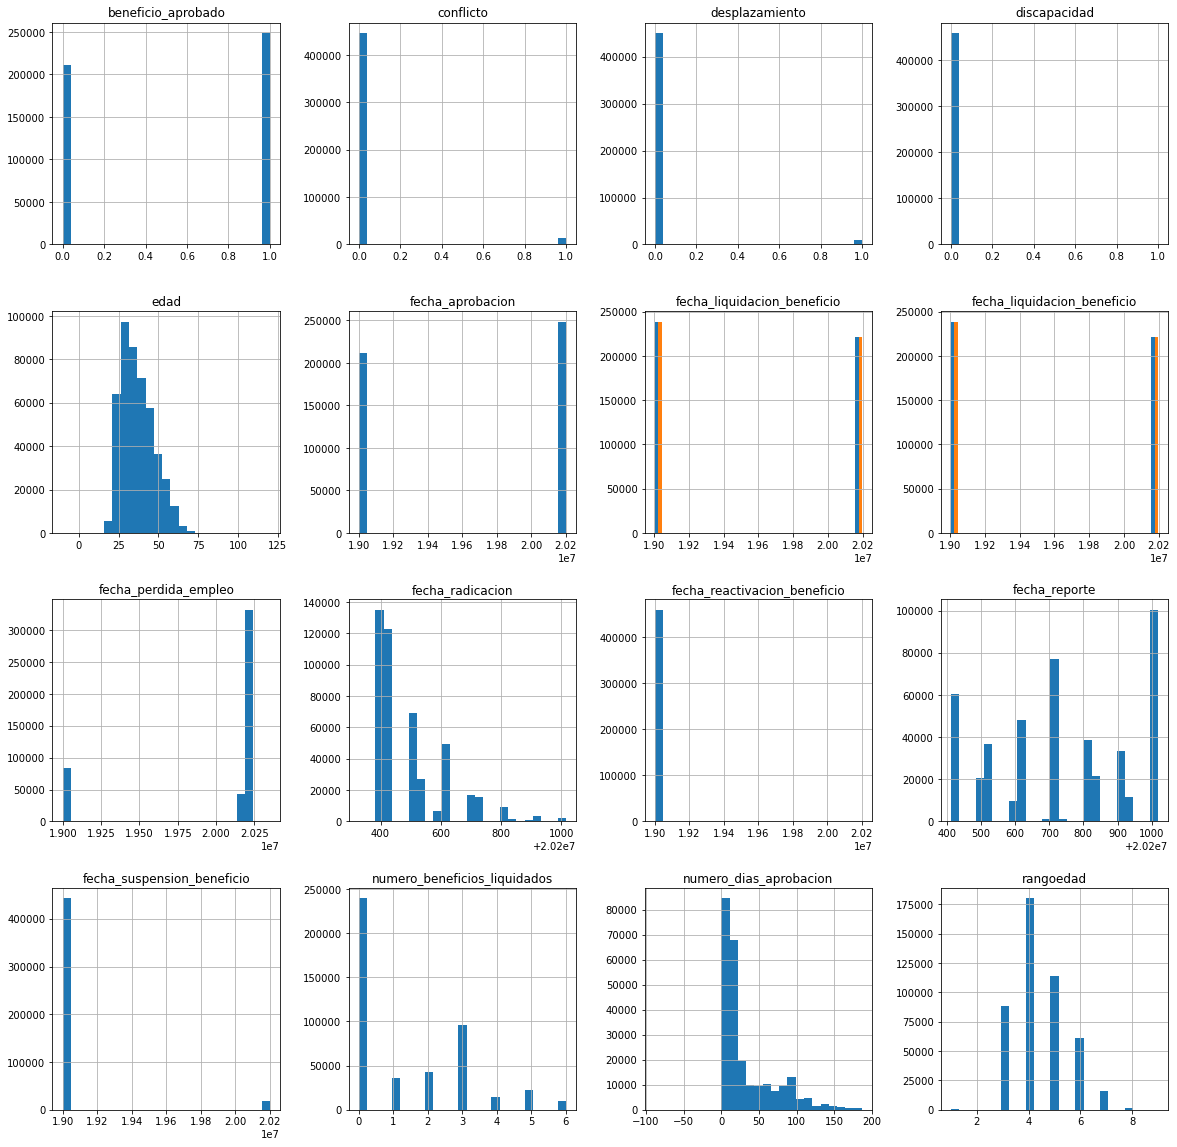

In [32]:
#plot variables
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
dfgoldenrecord.hist(bins = 25)

### Initial Correlation Analysis

Conduct a basic exploratory data analysis to see if any of the covariates appear to be related to the probability of the COVID subsidy to be approved. 

In [33]:
initialcorr=dfgoldenrecord.corr()

Text(0.5, 1.0, 'Correlation Matrix')

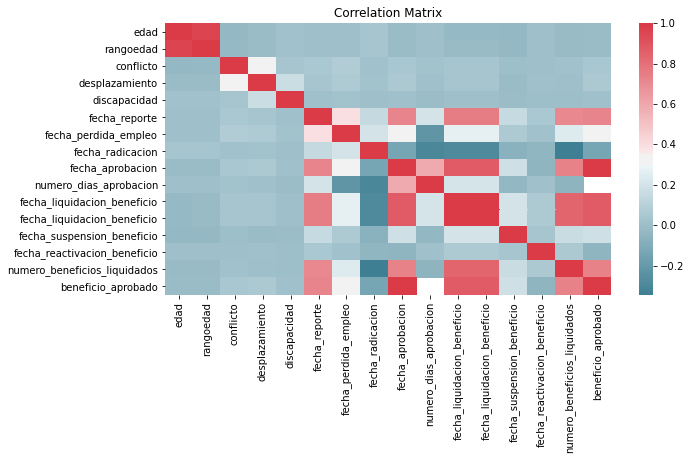

In [34]:
#plot correlation matrix
rcParams['figure.figsize'] = 10, 5
sns.heatmap(initialcorr,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

In [35]:
dfsmall=pd.DataFrame(dfgoldenrecord[['genero','rangoedad','categoria_afiliado', 'grupo_etnico','ubicacion_residencia','conflicto', 'desplazamiento', 'discapacidad', 'fecha_perdida_empleo','caja_name', 'region','beneficio_aprobado']])

Since correlations are best suited for analyzing linear relationships, let's create a matrix of 2D scatterplots for each pair of variables also, so that we can visually pick up on any potential non-linear relationships:

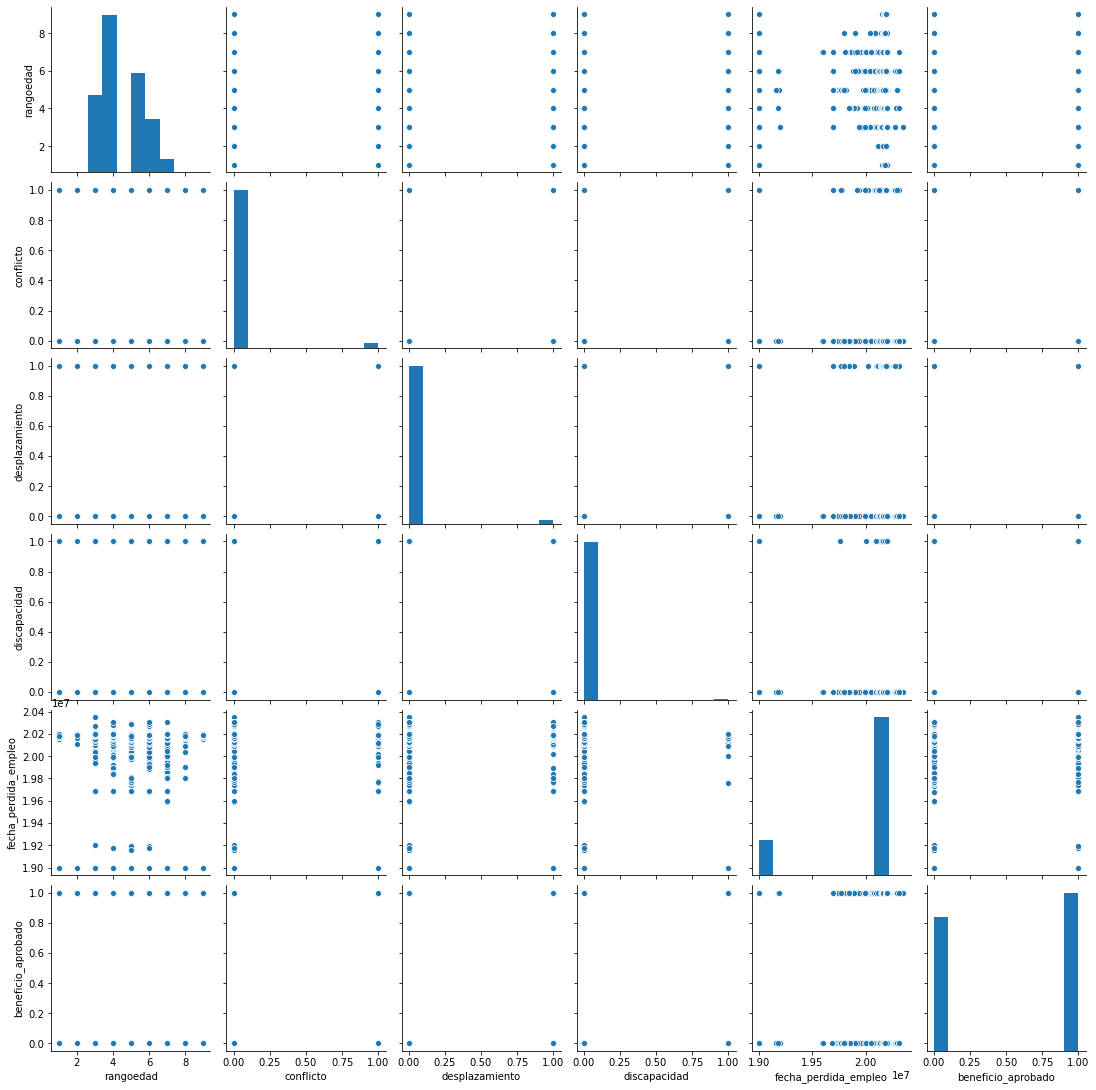

In [36]:
sns.pairplot(dfsmall)

### Beneficiario

In [37]:
df_beneficiario.head(3)

id  genero  edad     rangoedad categoria_afiliado  \
0   10585325085664329   MUJER    50  6.   48 - 57                  A   
1    7218856636626492  HOMBRE    60  7.   58 - 67                  B   
2  543423044184532083  HOMBRE    26  3.   18 - 27                  B   

  ubicacion_residencia               grupo_etnico caracteristica_poblacion  \
0               URBANA  NINGUNO DE LOS ANTERIORES                NO APLICA   
1                RURAL  NINGUNO DE LOS ANTERIORES                NO APLICA   
2               URBANA              NO DISPONIBLE                NO APLICA   

            fctor_vulnerabilidad  conflicto  ...                 region  \
0                      NO APLICA          0  ...  Región Centro Oriente   
1  EN CONDICIÃ“N DE DISCAPACIDAD          0  ...  Región Centro Oriente   
2                      NO APLICA          0  ...          Región Caribe   

   fecha_radicacion  fecha_aprobacion  numero_dias_aprobacion  \
0          20200424          19000101                     NaN   
1          20200508          20200514                     6.0   
2          20200407          19000101                     NaN   

  fecha_liquidacion_beneficio fecha_liquidacion_beneficio  \
0                    19000101                    19000101   
1                    20200630                    20200630   
2                    19000101                    19000101   

  fecha_suspension_beneficio fecha_reactivacion_beneficio  \
0                   19000101                     19000101   
1                   19000101                     19000101   
2                   19000101                     19000101   

   numero_beneficios_liquidados  beneficio_aprobado  
0                             0               False  
1                             3                True  
2                             0               False  

[3 rows x 27 columns]

#### rangoedad

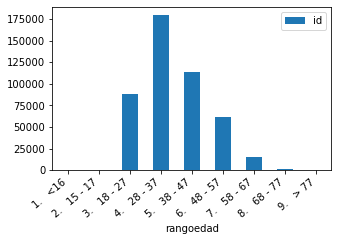

In [38]:
rcParams['figure.figsize'] = 5, 3
ax=df_beneficiario[['rangoedad','id']].groupby(pd.Grouper(key="rangoedad")).count().sort_values(by='rangoedad',ascending=True).plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### Genero

In [39]:
df_beneficiario['genero'].unique()

array(['MUJER', 'HOMBRE', 'INDETERMINADO'], dtype=object)

In [40]:
rcParams['figure.figsize'] = 5, 3
ax = sns.countplot(x=df_beneficiario['genero'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [41]:
df_beneficiario[['genero','id']].groupby(pd.Grouper(key="genero")).count().sort_values(by='id',ascending=False)

id
genero               
HOMBRE         241743
MUJER          218623
INDETERMINADO      11

#### categoria_afiliado

In [42]:
df_beneficiario['categoria_afiliado'].unique()

array(['A', 'B', 'C', 'D'], dtype=object)

In [43]:
rcParams['figure.figsize'] = 5, 3
ax = sns.countplot(x=df_beneficiario['categoria_afiliado'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [44]:
df_beneficiario[['categoria_afiliado','id']].groupby(pd.Grouper(key="categoria_afiliado")).count().sort_values(by='id',ascending=False)

id
categoria_afiliado        
A                   407047
B                    52021
C                     1276
D                       33

#### ubicacion_residencia

In [45]:
df_beneficiario['ubicacion_residencia'].unique()

array(['URBANA', 'RURAL'], dtype=object)

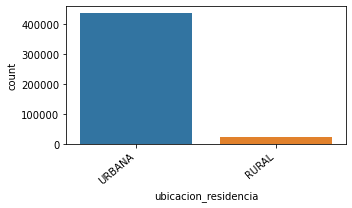

In [46]:
rcParams['figure.figsize'] = 5, 3
ax = sns.countplot(x=df_beneficiario['ubicacion_residencia'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

#### grupo_etnico

In [47]:
df_beneficiario['grupo_etnico'].unique()

array(['NINGUNO DE LOS ANTERIORES', 'NO DISPONIBLE', 'AFROCOLOMBIANO',
       'INDIGENA', 'ROOM/GITANO', 'COMUNIDAD NEGRA', 'PALANQUERO',
       'COMUNIDAD RAIZAL'], dtype=object)

In [48]:
rcParams['figure.figsize'] = 5, 3
ax = sns.countplot(x=df_beneficiario['grupo_etnico'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

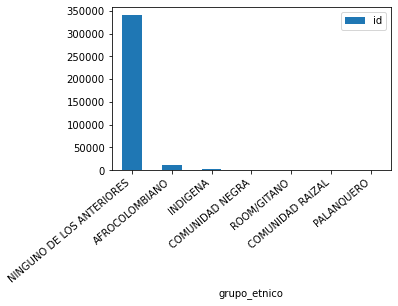

In [49]:
rcParams['figure.figsize'] = 5, 3
no_etnico= ['NO SE AUTO RECONOCE EN NINGUNO DE LOS ANTERIORES','NO DISPONIBLE']
ax =df_beneficiario[~df_beneficiario.grupo_etnico.isin(no_etnico)][['grupo_etnico','id']].groupby(pd.Grouper(key="grupo_etnico")).count().sort_values(by='id',ascending=False).plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### caracteristica_poblacion

In [50]:
df_beneficiario['caracteristica_poblacion'].unique()

array(['NO APLICA', 'EN CONDICION DE DISCAPACIDAD FISICA',
       'VICTIMAS DEL CONFLICTO ARMADO', 'EN CONDICION DE DESPLAZAMIENTO',
       'VICTIMAS DEL CONFLICTO ARMADO Y EN CONDICION DE DESPLAZAMIENTO',
       'EN CONDICION DE DESPLAZAMIENTO Y EN CONDICION DE DISCAPACIDAD FISICA',
       'VICTIMAS DEL CONFLICTO ARMADO EN CONDICION DE DESPLAZAMIENTO Y EN CONDICION DE DISCAPACIDAD FISICA',
       'VICTIMAS DEL CONFLICTO ARMADO Y EN CONDICION DE DISCAPACIDAD FISICA'],
      dtype=object)

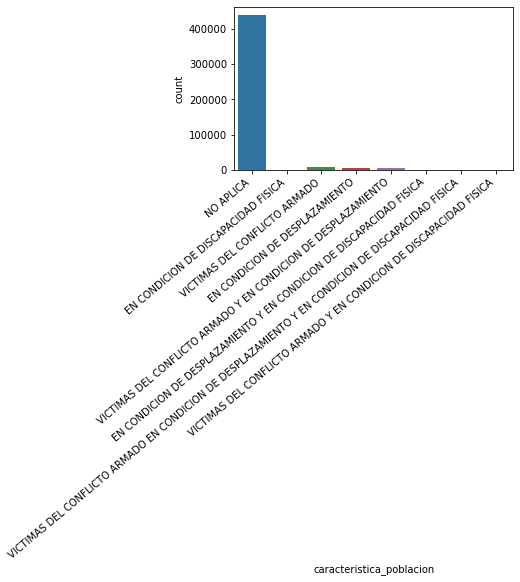

In [51]:
rcParams['figure.figsize'] = 5, 3
ax = sns.countplot(x=df_beneficiario['caracteristica_poblacion'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [52]:
rcParams['figure.figsize'] = 5, 3
ax =df_beneficiario[~df_beneficiario.caracteristica_poblacion.isin(['NO APLICA'])][['caracteristica_poblacion','id']].groupby(pd.Grouper(key='caracteristica_poblacion')).count().sort_values(by='id',ascending=False).plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

#### conflicto, desplazamiento y discapacidad 

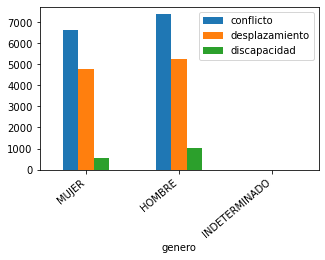

In [53]:
rcParams['figure.figsize'] = 5, 3
ax=df_beneficiario[['genero','conflicto','desplazamiento','discapacidad']].groupby(pd.Grouper(key="genero")).sum().plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

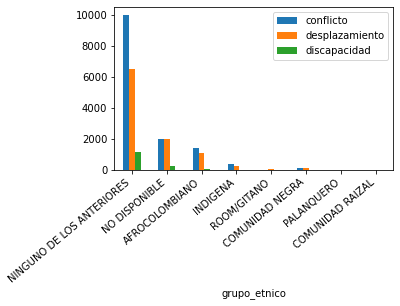

In [54]:
rcParams['figure.figsize'] = 5, 3
ax=df_beneficiario[['grupo_etnico','conflicto','desplazamiento','discapacidad']].groupby(pd.Grouper(key="grupo_etnico")).sum().plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

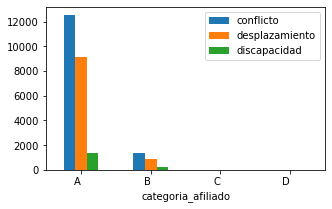

In [55]:
rcParams['figure.figsize'] = 5, 3
ax=df_beneficiario[['categoria_afiliado','conflicto','desplazamiento','discapacidad']].groupby(pd.Grouper(key="categoria_afiliado")).sum().plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
plt.show()

#### Region

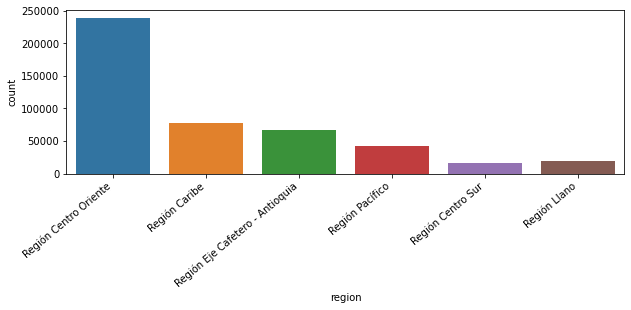

In [56]:
rcParams['figure.figsize'] = 10, 3
ax = sns.countplot(x=df_beneficiario['region'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

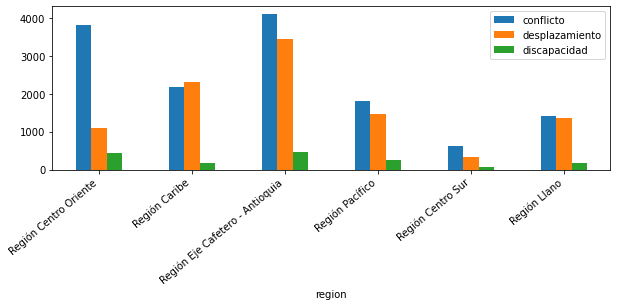

In [57]:
rcParams['figure.figsize'] = 10, 3
ax=df_beneficiario[['region','conflicto','desplazamiento','discapacidad']].groupby(pd.Grouper(key="region")).sum().plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

### caja_name

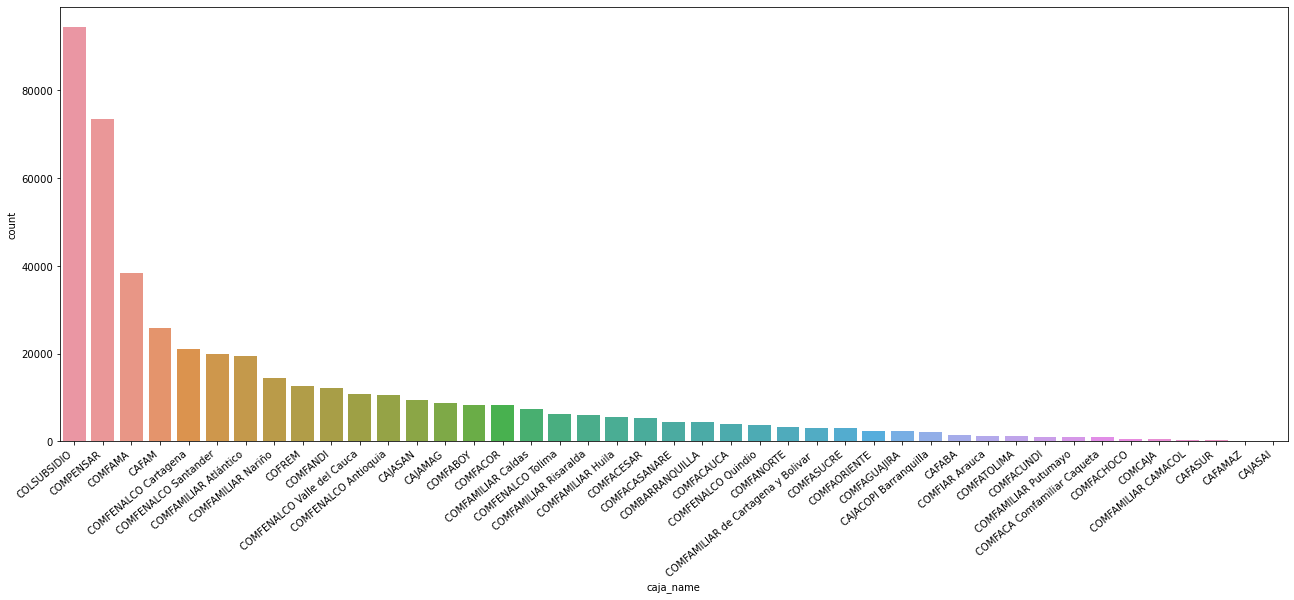

In [58]:
rcParams['figure.figsize'] = 22, 8
ax = sns.countplot(x=df_beneficiario['caja_name'], order= df_beneficiario['caja_name'].value_counts().index, orient="h")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

## Model 1

### Data selection

We inicially extract the data selected for our model:

In [59]:
#df with selected columns
model1 = pd.DataFrame(dfgoldenrecord[['id','genero','rangoedad','categoria_afiliado', 'grupo_etnico','ubicacion_residencia','conflicto', 'desplazamiento', 'discapacidad', 'fecha_perdida_empleo','caja_name', 'region','beneficio_aprobado']])

In [60]:
#columns from DF
model1.columns

Index(['id', 'genero', 'rangoedad', 'categoria_afiliado', 'grupo_etnico',
       'ubicacion_residencia', 'conflicto', 'desplazamiento', 'discapacidad',
       'fecha_perdida_empleo', 'caja_name', 'region', 'beneficio_aprobado'],
      dtype='object')

### Cleaning the model data

We remove the special characters from the data names:

In [61]:
model1.loc[model1['grupo_etnico'] == 'INDÃ�GENA', ['grupo_etnico']] = 'INDIGENA'

In [62]:
model1=model1.merge(not_cleaned_age[['id','rangoedad']],on='id',how='left')

In [63]:
model1.head(3)

id  genero  rangoedad_x categoria_afiliado  \
0  526723791937696782  HOMBRE            4                  A   
1   41519093314428873  HOMBRE            5                  A   
2    4494102545661300  HOMBRE            5                  A   

                grupo_etnico ubicacion_residencia  conflicto  desplazamiento  \
0  NINGUNO DE LOS ANTERIORES               URBANA          0               0   
1  NINGUNO DE LOS ANTERIORES               URBANA          0               0   
2  NINGUNO DE LOS ANTERIORES               URBANA          0               0   

   discapacidad  fecha_perdida_empleo    caja_name                 region  \
0             0              20200115    COMPENSAR  Región Centro Oriente   
1             0              20190228        CAFAM  Región Centro Oriente   
2             0              19000101  COLSUBSIDIO  Región Centro Oriente   

   beneficio_aprobado  rangoedad_y  
0                   1          NaN  
1                   1          NaN  
2                   0          NaN

In [64]:
model1['rangoedad_y'] = model1['rangoedad_y'].fillna(model1['rangoedad_x'])
model1.drop(['rangoedad_x'],axis=1,inplace=True)
model1.rename(columns = {'rangoedad_y':'rangoedad'}, inplace = True) 
model1.drop(['id'],axis=1,inplace=True)

In [65]:
model1.describe()

conflicto  desplazamiento   discapacidad  fecha_perdida_empleo  \
count  460377.000000   460377.000000  460377.000000          4.603770e+05   
mean        0.030356        0.021786       0.003449          1.997561e+07   
std         0.171564        0.145986       0.058630          4.622585e+05   
min         0.000000        0.000000       0.000000          1.900010e+07   
25%         0.000000        0.000000       0.000000          2.018073e+07   
50%         0.000000        0.000000       0.000000          2.020011e+07   
75%         0.000000        0.000000       0.000000          2.020032e+07   
max         1.000000        1.000000       1.000000          2.035052e+07   

       beneficio_aprobado      rangoedad  
count       460377.000000  460377.000000  
mean             0.540049       4.433039  
std              0.498394       1.062781  
min              0.000000       2.000000  
25%              0.000000       4.000000  
50%              1.000000       4.000000  
75%              1.000000       5.000000  
max              1.000000       8.000000

In [66]:
#columns from DF
model1.columns

Index(['genero', 'categoria_afiliado', 'grupo_etnico', 'ubicacion_residencia',
       'conflicto', 'desplazamiento', 'discapacidad', 'fecha_perdida_empleo',
       'caja_name', 'region', 'beneficio_aprobado', 'rangoedad'],
      dtype='object')

### One hot encoding

In [67]:
#one hot encoding
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['grupo_etnico'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['categoria_afiliado'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['ubicacion_residencia'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['region'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['caja_name'], drop_first=True)) #Use drop_first to drop the first category
model1 = pd.DataFrame(pd.get_dummies(model1,columns=['genero'], drop_first=True)) #Use drop_first to drop the first category


In [68]:
model1.head(2)

conflicto  desplazamiento  discapacidad  fecha_perdida_empleo  \
0          0               0             0              20200115   
1          0               0             0              20190228   

   beneficio_aprobado  rangoedad  grupo_etnico_COMUNIDAD NEGRA  \
0                   1        4.0                             0   
1                   1        5.0                             0   

   grupo_etnico_COMUNIDAD RAIZAL  grupo_etnico_INDIGENA  \
0                              0                      0   
1                              0                      0   

   grupo_etnico_NINGUNO DE LOS ANTERIORES  ...  \
0                                       1  ...   
1                                       1  ...   

   caja_name_COMFENALCO Antioquia  caja_name_COMFENALCO Cartagena  \
0                               0                               0   
1                               0                               0   

   caja_name_COMFENALCO Quindio  caja_name_COMFENALCO Santander  \
0                             0                               0   
1                             0                               0   

   caja_name_COMFENALCO Tolima  caja_name_COMFENALCO Valle del Cauca  \
0                            0                                     0   
1                            0                                     0   

   caja_name_COMFIAR Arauca  caja_name_COMPENSAR  genero_INDETERMINADO  \
0                         0                    1                     0   
1                         0                    0                     0   

   genero_MUJER  
0             0  
1             0  

[2 rows x 66 columns]

In [69]:
#size of DF
model1.shape

(460377, 66)

In [70]:
#clean columns and replace
model1.columns = [c.replace(' ', '_') for c in model1.columns]
model1.rename(columns={'region_Región_Eje_Cafetero_-_Antioquia':'region_Región_Eje_Cafetero_Antioquia'}, inplace=True)

### Correlation Matrix

In [71]:
#correlation matrix
corr_mat  = model1.corr()
corr_mat

conflicto  desplazamiento  discapacidad  \
conflicto                              1.000000        0.338539      0.037530   
desplazamiento                         0.338539        1.000000      0.166582   
discapacidad                           0.037530        0.166582      1.000000   
fecha_perdida_empleo                   0.079137        0.069629      0.026435   
beneficio_aprobado                     0.046001        0.056762      0.015863   
...                                         ...             ...           ...   
caja_name_COMFENALCO_Valle_del_Cauca   0.010802        0.011226      0.008437   
caja_name_COMFIAR_Arauca               0.012806        0.048560      0.037082   
caja_name_COMPENSAR                    0.022437       -0.064957     -0.016617   
genero_INDETERMINADO                  -0.000865       -0.000729     -0.000288   
genero_MUJER                          -0.000797        0.000804     -0.013881   

                                      fecha_perdida_empleo  \
conflicto                                         0.079137   
desplazamiento                                    0.069629   
discapacidad                                      0.026435   
fecha_perdida_empleo                              1.000000   
beneficio_aprobado                                0.322349   
...                                                    ...   
caja_name_COMFENALCO_Valle_del_Cauca              0.074277   
caja_name_COMFIAR_Arauca                          0.025424   
caja_name_COMPENSAR                               0.163210   
genero_INDETERMINADO                             -0.005718   
genero_MUJER                                      0.023336   

                                      beneficio_aprobado  rangoedad  \
conflicto                                       0.046001  -0.023525   
desplazamiento                                  0.056762  -0.013459   
discapacidad                                    0.015863   0.019289   
fecha_perdida_empleo                            0.322349   0.010970   
beneficio_aprobado                              1.000000  -0.009570   
...                                                  ...        ...   
caja_name_COMFENALCO_Valle_del_Cauca            0.045962   0.005319   
caja_name_COMFIAR_Arauca                        0.045432   0.006111   
caja_name_COMPENSAR                            -0.055402  -0.022285   
genero_INDETERMINADO                           -0.000839   0.000099   
genero_MUJER                                    0.013169  -0.080670   

                                      grupo_etnico_COMUNIDAD_NEGRA  \
conflicto                                                 0.027185   
desplazamiento                                            0.034621   
discapacidad                                              0.007204   
fecha_perdida_empleo                                      0.017855   
beneficio_aprobado                                        0.015137   
...                                                            ...   
caja_name_COMFENALCO_Valle_del_Cauca                      0.036518   
caja_name_COMFIAR_Arauca                                  0.006253   
caja_name_COMPENSAR                                      -0.015791   
genero_INDETERMINADO                                     -0.000191   
genero_MUJER                                             -0.002777   

                                      grupo_etnico_COMUNIDAD_RAIZAL  \
conflicto                                                  0.005122   
desplazamiento                                             0.004155   
discapacidad                                               0.003711   
fecha_perdida_empleo                                       0.006506   
beneficio_aprobado                                         0.004051   
...                                                             ...   
caja_name_COMFENALCO_Valle_del_Cauca                       0.002013   
caja_name_COMFIAR_Arauca                                  

Text(0.5, 1.0, 'Correlation Matrix')

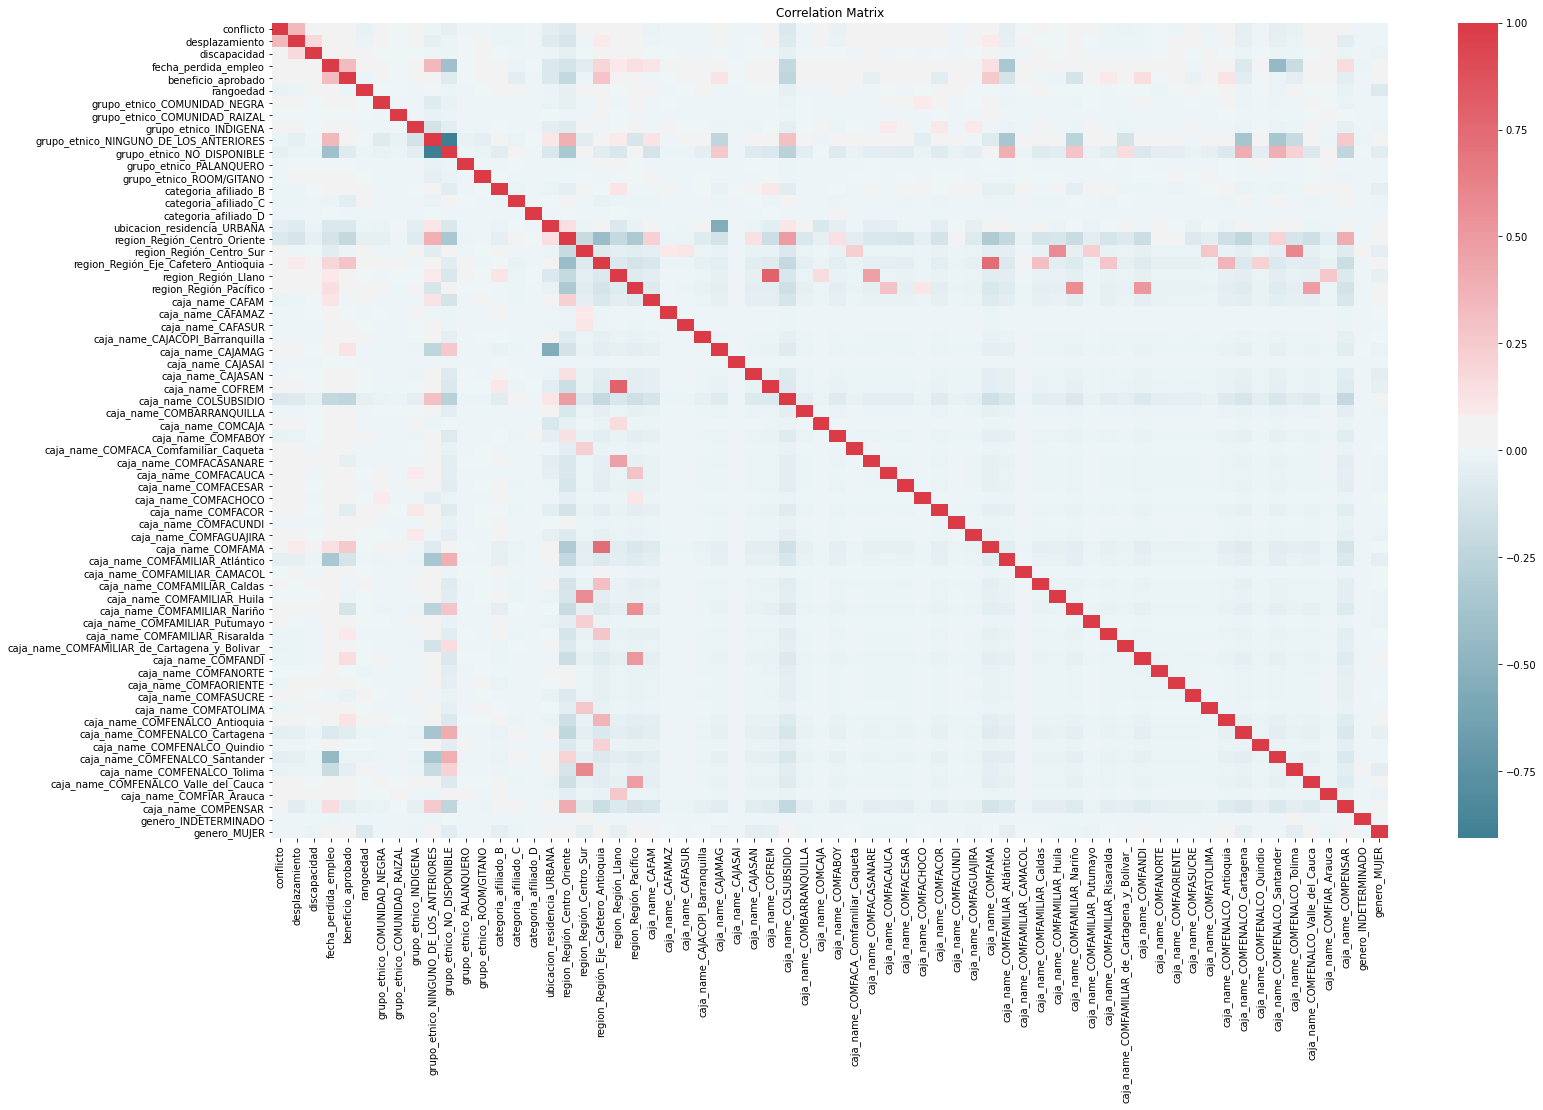

In [72]:
#plot correlation matrix
rcParams['figure.figsize'] = 25, 15
sns.heatmap(corr_mat,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

### Get Sample

In [73]:
#sample 100000 observations from DF
sample = model1.sample(100000)
#.sample(10000)
sample.shape

(100000, 66)

In [74]:
#look for null values
sample.isnull().sum()

conflicto                               0
desplazamiento                          0
discapacidad                            0
fecha_perdida_empleo                    0
beneficio_aprobado                      0
                                       ..
caja_name_COMFENALCO_Valle_del_Cauca    0
caja_name_COMFIAR_Arauca                0
caja_name_COMPENSAR                     0
genero_INDETERMINADO                    0
genero_MUJER                            0
Length: 66, dtype: int64

In [75]:
#preview DF
pd.set_option('display.max_columns',100)
sample.head()

conflicto  desplazamiento  discapacidad  fecha_perdida_empleo  \
302594          1               0             0              20200229   
28057           1               1             0              20200313   
59758           0               0             0              20200501   
122007          0               0             0              20200316   
421185          0               0             0              20200331   

        beneficio_aprobado  rangoedad  grupo_etnico_COMUNIDAD_NEGRA  \
302594                   1        6.0                             0   
28057                    0        5.0                             0   
59758                    1        3.0                             0   
122007                   1        5.0                             0   
421185                   0        4.0                             0   

        grupo_etnico_COMUNIDAD_RAIZAL  grupo_etnico_INDIGENA  \
302594                              0                      0   
28057                               0                      0   
59758                               0                      0   
122007                              0                      0   
421185                              0                      0   

        grupo_etnico_NINGUNO_DE_LOS_ANTERIORES  grupo_etnico_NO_DISPONIBLE  \
302594                                       1                           0   
28057                                        0                           1   
59758                                        1                           0   
122007                                       1                           0   
421185                                       1                           0   

        grupo_etnico_PALANQUERO  grupo_etnico_ROOM/GITANO  \
302594                        0                         0   
28057                         0                         0   
59758                         0                         0   
122007                        0                         0   
421185                        0                         0   

        categoria_afiliado_B  categoria_afiliado_C  categoria_afiliado_D  \
302594                     1                     0                     0   
28057                      0                     0                     0   
59758                      0                     0                     0   
122007                     0                     0                     0   
421185                     0                     0                     0   

        ubicacion_residencia_URBANA  region_Región_Centro_Oriente  \
302594                            1                             0   
28057                             1                             0   
59758                             1                             0   
122007                            1                             0   
421185                            1                             1   

        region_Región_Centro_Sur  region_Región_Eje_Cafetero_Antioquia  \
302594                         0                                     0   
28057                          0                                     0   
59758                          0                                     0   
122007                         0                                     0   
421185                         0                                     0   

        region_Región_Llano  region_Región_Pacífico  caja_name_CAFAM  \
302594                    1                       0                0   
28057                     0                       1                0   
59758                     0                       1                0   
122007                    0                       0                0   
421185                    0                       0                0   

        caja_name_CAFAMAZ  caja_name_CAFASUR  caja_name_CAJACOPI_Barranquilla  \
302594                  0                  0                                0   
28057    

In [76]:
sample.shape

(100000, 66)

### Normalize Columns

In [77]:
# We have 2 columns that are not on the same scale as others. Lets normalize them
column_normalize = ['rangoedad', 'fecha_perdida_empleo']

for col in column_normalize:
    sample[col] = minmax_scale(sample[col])

In [78]:
sample.head()

conflicto  desplazamiento  discapacidad  fecha_perdida_empleo  \
302594          1               0             0              0.923098   
28057           1               1             0              0.923163   
59758           0               0             0              0.923307   
122007          0               0             0              0.923165   
421185          0               0             0              0.923176   

        beneficio_aprobado  rangoedad  grupo_etnico_COMUNIDAD_NEGRA  \
302594                   1   0.666667                             0   
28057                    0   0.500000                             0   
59758                    1   0.166667                             0   
122007                   1   0.500000                             0   
421185                   0   0.333333                             0   

        grupo_etnico_COMUNIDAD_RAIZAL  grupo_etnico_INDIGENA  \
302594                              0                      0   
28057                               0                      0   
59758                               0                      0   
122007                              0                      0   
421185                              0                      0   

        grupo_etnico_NINGUNO_DE_LOS_ANTERIORES  grupo_etnico_NO_DISPONIBLE  \
302594                                       1                           0   
28057                                        0                           1   
59758                                        1                           0   
122007                                       1                           0   
421185                                       1                           0   

        grupo_etnico_PALANQUERO  grupo_etnico_ROOM/GITANO  \
302594                        0                         0   
28057                         0                         0   
59758                         0                         0   
122007                        0                         0   
421185                        0                         0   

        categoria_afiliado_B  categoria_afiliado_C  categoria_afiliado_D  \
302594                     1                     0                     0   
28057                      0                     0                     0   
59758                      0                     0                     0   
122007                     0                     0                     0   
421185                     0                     0                     0   

        ubicacion_residencia_URBANA  region_Región_Centro_Oriente  \
302594                            1                             0   
28057                             1                             0   
59758                             1                             0   
122007                            1                             0   
421185                            1                             1   

        region_Región_Centro_Sur  region_Región_Eje_Cafetero_Antioquia  \
302594                         0                                     0   
28057                          0                                     0   
59758                          0                                     0   
122007                         0                                     0   
421185                         0                                     0   

        region_Región_Llano  region_Región_Pacífico  caja_name_CAFAM  \
302594                    1                       0                0   
28057                     0                       1                0   
59758                     0                       1                0   
122007                    0                       0                0   
421185                    0                       0                0   

        caja_name_CAFAMAZ  caja_name_CAFASUR  caja_name_CAJACOPI_Barranquilla  \
302594                  0                  0                                0   
28057    

### Training and testin data sets 

In [79]:
    # Setting target variable
y = sample['beneficio_aprobado']
    
# Making feature data set by removing target variable  from it
   
x = sample.drop(['beneficio_aprobado'], axis=1)
    
    # Making training and testing data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Train the model

In [80]:
from sklearn.metrics import mean_squared_error, make_scorer
model = RandomForestClassifier()

# Fitting model instance on training data
model.fit(x_train, y_train)
    
# Model predictions on train data 
y_train_predict = model.predict(x_train)

# Model predictions on test data 
y_test_predict = model.predict(x_test)
#my_s = make_scorer(mean_squared_error)
scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')
scores.mean()

0.7093399999999999

In [81]:
confusion_matrix(y_test, y_test_predict)

array([[ 9433,  4492],
       [ 4334, 11741]], dtype=int64)

In [82]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68     13925
           1       0.72      0.73      0.73     16075

    accuracy                           0.71     30000
   macro avg       0.70      0.70      0.70     30000
weighted avg       0.71      0.71      0.71     30000



In [83]:
import joblib

# save the model to disk
filename = 'Modelo_RF1.sav'

# grabar el modelo generado (mod) en el archivo (filename)
joblib.dump(model, filename)

['Modelo_RF1.sav']

In [84]:
sample.columns

Index(['conflicto', 'desplazamiento', 'discapacidad', 'fecha_perdida_empleo',
       'beneficio_aprobado', 'rangoedad', 'grupo_etnico_COMUNIDAD_NEGRA',
       'grupo_etnico_COMUNIDAD_RAIZAL', 'grupo_etnico_INDIGENA',
       'grupo_etnico_NINGUNO_DE_LOS_ANTERIORES', 'grupo_etnico_NO_DISPONIBLE',
       'grupo_etnico_PALANQUERO', 'grupo_etnico_ROOM/GITANO',
       'categoria_afiliado_B', 'categoria_afiliado_C', 'categoria_afiliado_D',
       'ubicacion_residencia_URBANA', 'region_Región_Centro_Oriente',
       'region_Región_Centro_Sur', 'region_Región_Eje_Cafetero_Antioquia',
       'region_Región_Llano', 'region_Región_Pacífico', 'caja_name_CAFAM',
       'caja_name_CAFAMAZ', 'caja_name_CAFASUR',
       'caja_name_CAJACOPI_Barranquilla', 'caja_name_CAJAMAG',
       'caja_name_CAJASAI', 'caja_name_CAJASAN', 'caja_name_COFREM',
       'caja_name_COLSUBSIDIO', 'caja_name_COMBARRANQUILLA',
       'caja_name_COMCAJA', 'caja_name_COMFABOY',
       'caja_name_COMFACA_Comfamiliar_Caqueta', 'ca